In [ ]:
# collab:
# !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

# Частично идея/текст этого семинара взята с седьмого семинара про авторегрессионным моделям на курсе дл у Осокина

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

%matplotlib inline

Код снизу:
1. Клонит репозиторий с кодом для обработки постеров
2. Скачивает 40к постеров
3. Откладывает 100 постеров в валидационную папочку

In [2]:
# !git clone https://github.com/benckx/dnn-movie-posters.git
# !cd dnn-movie-posters && python3 ./get_data.py -download

# val_files = os.listdir(data_path + '100/')[-100:]
# os.makedirs(val_data_path, exist_ok=True)
# os.makedirs(val_data_path + '100/', exist_ok=True)
# for file in val_files:
#     os.rename(data_path + '100/' + file, val_data_path + '100/'+ file)


In [3]:
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_buckets = 10

original_shape = [268, 182]
resize_n = 3


#### Задание 1:

Напишите функцию, которая будет принимать на вход тензор batch x channels x width x height, где каждый элемент - int от 0 до 255, а возвращать тензор такой же размерности, но с элементами int, от 0 до 9 

In [6]:
def bucketize(x):
    # YOUR CODE
    return x

#### Задание 2:

Каждое изображение - PIL IMAGE формата `3 x original_shape[0] x original_shape[1]`

Необходимо:
1. Уменьшить изображение в `resize_n` раз
2. Перевести изображение в Grayscale, RGB - черно-белое
3. Преобразовать PIL IMAGE в тензор
4. Применить bucketize


In [11]:
poster_transforms = transforms.Compose([ 
    # YOUR CODE
    transforms.ToTensor(), # PIL Image -> Tensor
    transforms.Lambda(lambda x: bucketize(x)),
])


In [12]:
data_path = "./dnn-movie-posters/data/images/"
val_data_path = './dnn-movie-posters/data/val/'


train_dataset = datasets.ImageFolder(data_path, transform=poster_transforms)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

val_dataset = datasets.ImageFolder(val_data_path, transform=poster_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)


In [13]:
image, _ = next(iter(train_loader))
image.shape

torch.Size([32, 1, 89, 60])

In [18]:
def plot_image(image, cmap=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(image.detach().cpu().permute(1, 2, 0).squeeze(), cmap=cmap)
    plt.show()


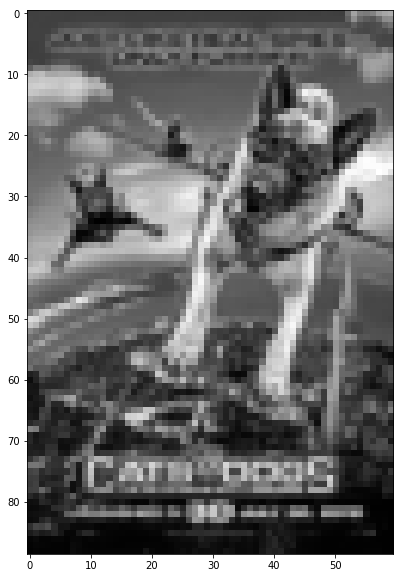

In [19]:
plot_image(image[0], cmap='gray')

### PixelCNN

Коротко вспомним, что такое PixelCNN. Авторегрессионные модели в общем виде моделируют распределения на векторах $x = (x_1, \ldots, x_N)$ в виде:

$$
    p(x) = \prod_{i=1}^{N} p(x_i \mid x_1, \ldots, x_{i-1}).
$$

Распределения $p(x_i \mid x_1, \ldots, x_{i-1})$ можно моделировать при помощи моделей, которые получают на вход значения $x_1, \ldots, x_{i-1}$ и выдают распределение вероятностей для значений $x_i$.

Здесь можно использовать рекуррентные сети (например, PixelRNN), но неплохо работает и более простая модель &mdash; PixelCNN, &mdash; которая подает на вход не все значения $x_1, \ldots, x_{i-1}$, а только соседние на некотором расстоянии с помощью сверточных слоев.

![pixelcnn](https://raw.githubusercontent.com/aleju/papers/master/neural-nets/images/Conditional_Image_Generation_with_PixelCNN_Decoders__masked_convolution.png)

#### Задача 3

Напишите функцию, которая будет генерировать такую маску

In [13]:
def make_mask(include_center, height, width):
    mask = torch.ones(height, width).long()
    # YOUR CODE
    return mask

In [14]:
class MaskedCNN(nn.Conv2d):
    def __init__(self, include_center, *args, **kwargs):
        super(MaskedCNN, self).__init__(*args, **kwargs)
        self.include_center = include_center
        self.register_buffer('mask', self.weight.data.clone())

        _, depth, height, width = self.weight.size()
        self.mask.fill_(1)
        self.mask[:,:] = make_mask(self.include_center, height, width)

    def forward(self, x):
        self.weight.data*=self.mask
        return super(MaskedCNN, self).forward(x)

#### Задача 4

Опишите свою модель

In [15]:
class PixelCNN(nn.Module):
    def __init__(self, input_channels=1, num_pixels=10):
        super(PixelCNN,self).__init__()
        self.layers = nn.Sequential(
            # YOUR CODE
        )
    def forward(self, x):
        x = x.float()
        x = self.layers(x)
        return x
        
    def generate_samples(self, starting_image, starting_point=(0, 0)):
        self.eval()
        # YOUR CODE
        # hint, use torch.multinomial
        return filled_image


In [16]:
def plot_losses(losses):
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.show()

In [17]:
model = PixelCNN().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [18]:
logits = model(image.to(device))
logits.shape

torch.Size([32, 10, 134, 91])

In [ ]:
losses = []
starting_x, starting_y = 10, 10

for i in range(50):
    model.train()
    for ind, (image, _) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        optimizer.zero_grad()
        image = image.to(device)
        logits = model(image)
        loss = criterion(logits,
                         image.long().squeeze())
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    clear_output()
    model.eval()
    image, _ = next(iter(val_loader))
    starting_image = image.clone()
    starting_image[:, :, starting_x:, starting_y:] = 0
    sample = model.generate_samples(starting_image[:2].to(device), (starting_x, starting_y))
    plot_image(sample[0])
    plot_losses(losses)
    

In [24]:
model.eval()
starting_image = image[:8].clone()
starting_image[:, :, 30:, 30:] = 0
sample = model.generate_samples(starting_image.to(device), starting_point=(30, 30))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [5]:
for i in sample:
    plot_image(i, cmap='gray')

#### Вопрос

Что делать когда у нас не черно-белые, а цветные изображения?